In [1]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from   IPython.display                 import display
from   pylab                           import rcParams

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import  mean_squared_error

import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

### 1.Read the data as an appropriate Time Series data and plot the data.

In [2]:
dfs = pd.read_csv('Sparkling.csv',parse_dates=['YearMonth'],index_col='YearMonth')
dfs.head()

,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471


In [3]:
rcParams['figure.figsize'] = 14,7

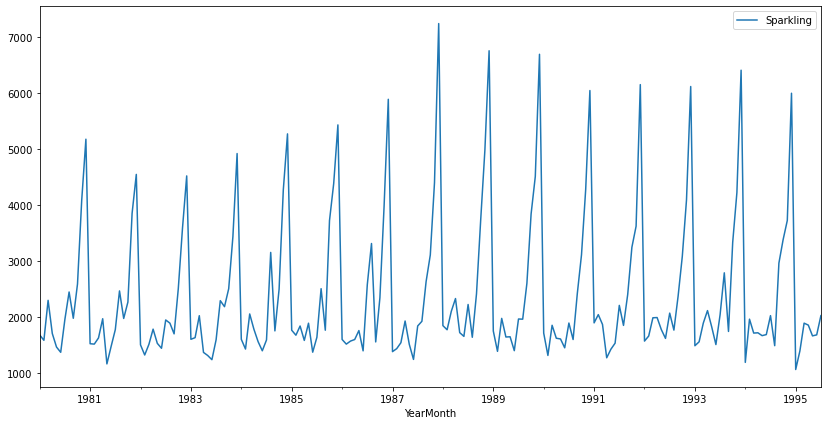

In [4]:
dfs.plot();

### 2.Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

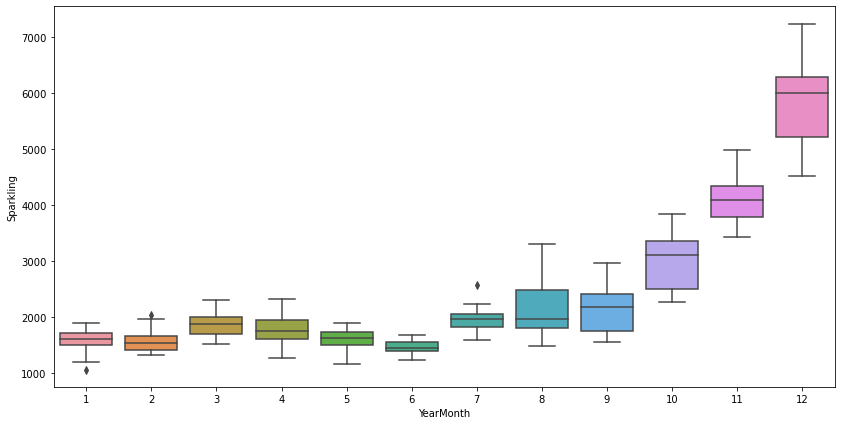

In [5]:
#Variation of Sparkling wines across Months
sns.boxplot(x=dfs.index.month,y=dfs['Sparkling']);

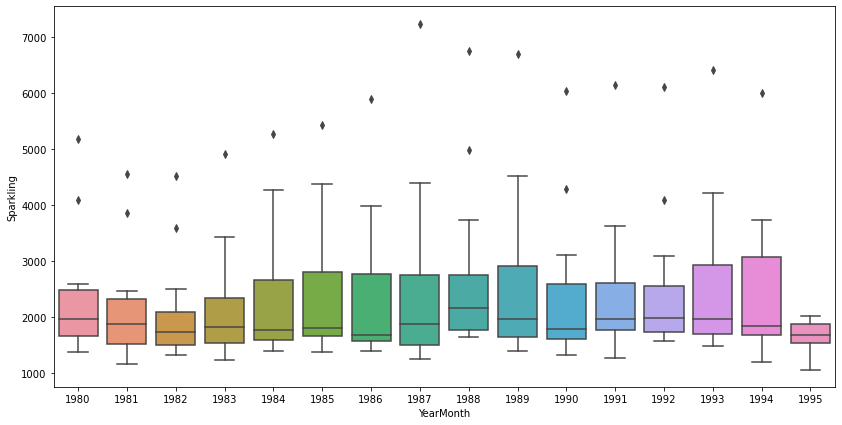

In [6]:
#Variation of Sparkling wines across years
sns.boxplot(x=dfs.index.year,y=dfs['Sparkling']);

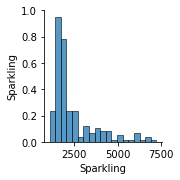

In [7]:
sns.pairplot(dfs);

In [8]:
dfs.isnull().sum()

Sparkling    0
dtype: int64

In [9]:
dfs_new = dfs

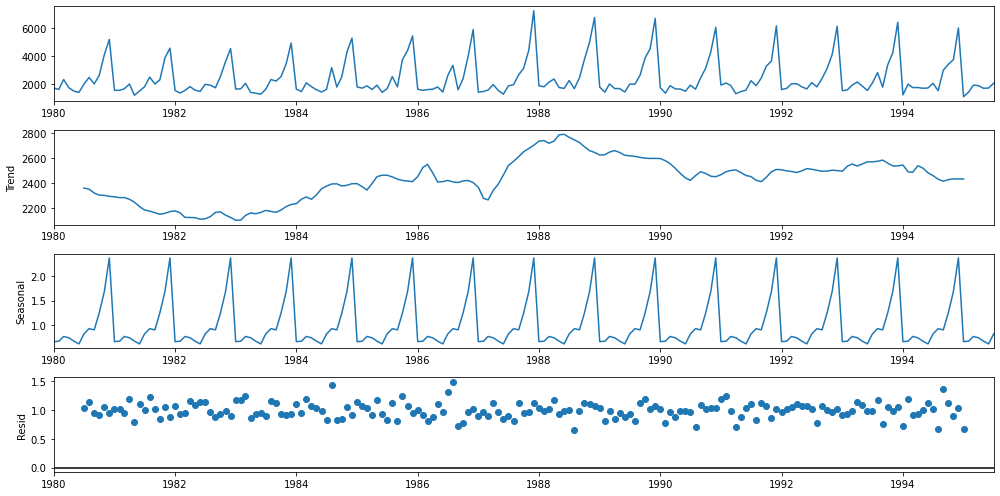

In [10]:
deco_snew = seasonal_decompose(dfs_new,model='multiplicative')
deco_snew.plot();

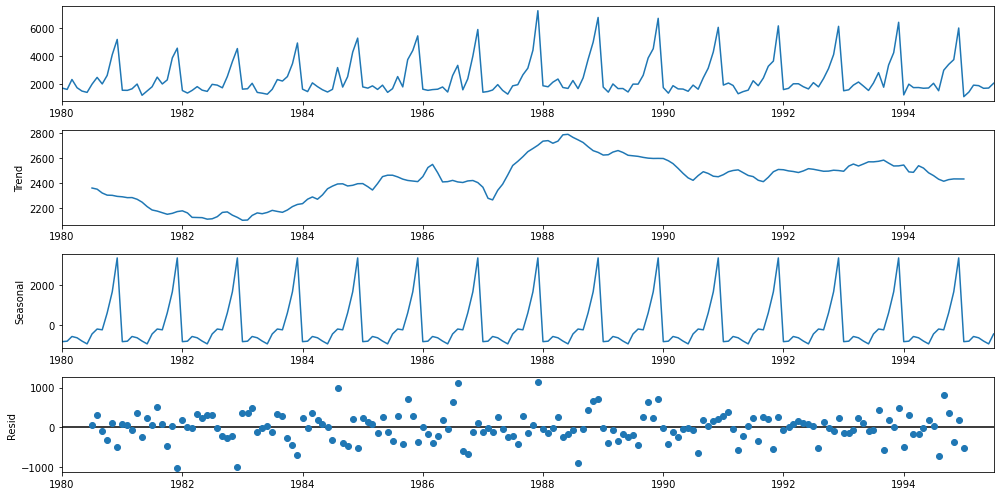

In [11]:
deco_snew = seasonal_decompose(dfs_new,model='additive')
deco_snew.plot();

Upon observing the residual, multiplicative decomposition suits the data series.

### 3.Split the data into training and test. The test data should start in 1991.

In [12]:
train_spark   =   dfs_new[0:int(len(dfs_new)*0.71)] 
test_spark   =   dfs_new[int(len(dfs_new)*0.71):]

In [13]:
print(train_spark.head(),'\n')
print(train_spark.tail(),'\n\n')
print(test_spark.head(),'\n')
print(test_spark.tail(),'\n')

            Sparkling
YearMonth            
1980-01-01       1686
1980-02-01       1591
1980-03-01       2304
1980-04-01       1712
1980-05-01       1471 

            Sparkling
YearMonth            
1990-08-01       1605
1990-09-01       2424
1990-10-01       3116
1990-11-01       4286
1990-12-01       6047 


            Sparkling
YearMonth            
1991-01-01       1902
1991-02-01       2049
1991-03-01       1874
1991-04-01       1279
1991-05-01       1432 

            Sparkling
YearMonth            
1995-03-01       1897
1995-04-01       1862
1995-05-01       1670
1995-06-01       1688
1995-07-01       2031 



### 4. Build various exponential smoothing models on the training data and evaluate the model using RMSE on the test data.Other models such as regression,naïve forecast models, simple average models etc. should also be built on the training data and check the performance on the test data using RMSE.

#### 2.1) Linear Regression model

In [14]:
train_time_spark = [i+1 for i in range(len(train_spark))]
test_time_spark = [i+133 for i in range(len(test_spark))]

lr_train_spark = train_spark.copy()
lr_test_spark = test_spark.copy()
lr_train_spark['time'] = train_time_spark
lr_test_spark['time'] = test_time_spark
lr_train_spark.head()

lr_spark = LinearRegression()
lr_spark.fit(lr_train_spark[['time']], lr_train_spark['Sparkling'])

train_spark_pred_mod_lr     = lr_spark.predict(lr_train_spark[['time']])
lr_train_spark['RegOnTime'] = train_spark_pred_mod_lr

test_spark_pred_mod_lr     = lr_spark.predict(lr_test_spark[['time']])
lr_test_spark['RegOnTime'] = test_spark_pred_mod_lr

In [15]:
lr_rmse_mod_test_spark = mean_squared_error(lr_test_spark['Sparkling'], test_spark_pred_mod_lr, squared=False)
sw_rmse = pd.DataFrame({'RMSE': [lr_rmse_mod_test_spark]},index=['Linear Regression'])
sw_rmse

,RMSE
Linear Regression,1389.135175


#### 2.2) Naive model

In [16]:
nm_train_spark = train_spark.copy()
nm_test_spark = test_spark.copy()

nm_test_spark['naive'] = np.asarray(train_spark['Sparkling'])[len(np.asarray(train_spark['Sparkling']))-1]

In [17]:
nm_rmse_mod_test_spark = mean_squared_error(lr_test_spark['Sparkling'], test_spark_pred_mod_lr, squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [nm_rmse_mod_test_spark]},index=['Naive Model'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175


#### 2.3) Simple Average model

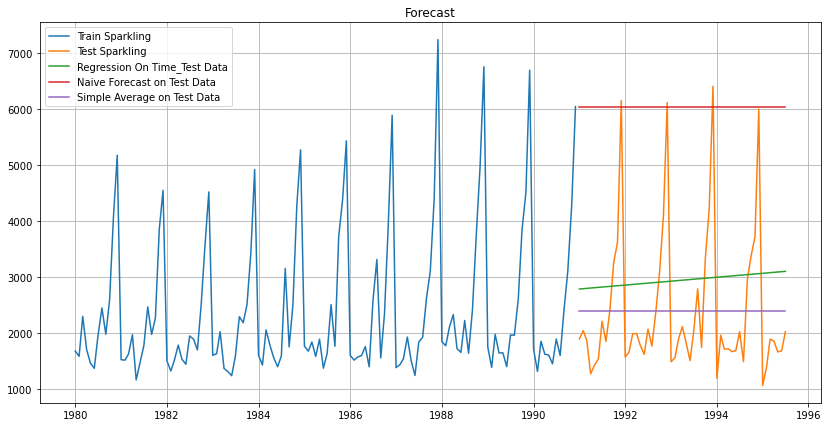

In [18]:
sa_train_spark = train_spark.copy()
sa_test_spark = test_spark.copy()

sa_test_spark['mean_forecast'] = train_spark['Sparkling'].mean()

plt.plot(sa_train_spark['Sparkling'], label='Train Sparkling')
plt.plot(sa_test_spark['Sparkling'], label='Test Sparkling')

plt.plot(lr_test_spark['RegOnTime'], label='Regression On Time_Test Data')
plt.plot(nm_test_spark['naive'], label='Naive Forecast on Test Data')
plt.plot(sa_test_spark['mean_forecast'], label='Simple Average on Test Data')

plt.legend(loc='best')
plt.title("Forecast")
plt.grid();

In [19]:
sa_rmse_mod_test_spark = metrics.mean_squared_error(test_spark['Sparkling'], sa_test_spark['mean_forecast'],squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [sa_rmse_mod_test_spark]},index=['Simple Average'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175
Simple Average,1275.081804


#### 2.4) Moving Average model

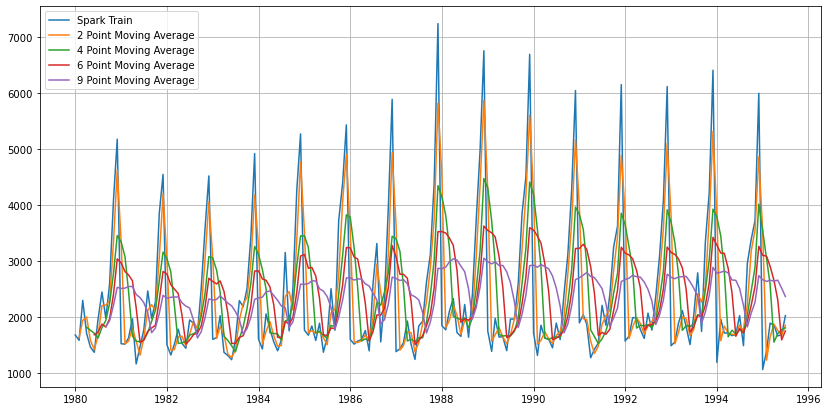

In [20]:
ma_spark= dfs.copy()

ma_spark['Trailing_2'] = ma_spark['Sparkling'].rolling(2).mean()
ma_spark['Trailing_4'] = ma_spark['Sparkling'].rolling(4).mean()
ma_spark['Trailing_6'] = ma_spark['Sparkling'].rolling(6).mean()
ma_spark['Trailing_9'] = ma_spark['Sparkling'].rolling(9).mean()

plt.plot(ma_spark['Sparkling'], label= 'Spark Train')
plt.plot(ma_spark['Trailing_2'], label= '2 Point Moving Average')
plt.plot(ma_spark['Trailing_4'], label= '4 Point Moving Average')
plt.plot(ma_spark['Trailing_6'], label = '6 Point Moving Average')
plt.plot(ma_spark['Trailing_9'], label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [21]:
#Creating train & test set
ma_train_spark = ma_spark[ma_spark.index<'1991']
ma_test_spark  = ma_spark[ma_spark.index>='1991']

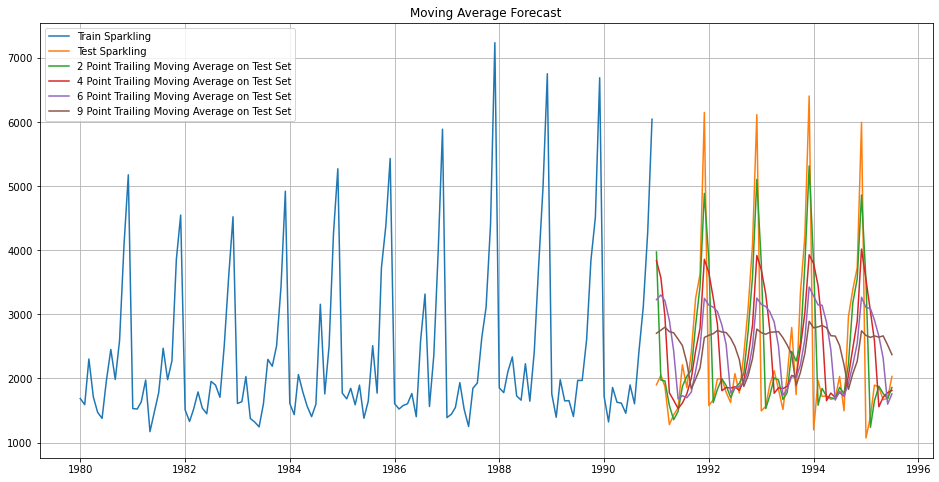

In [22]:
## Plotting on both the Training and Test data
plt.figure(figsize=(16,8))
plt.plot(ma_train_spark['Sparkling'], label='Train Sparkling')
plt.plot(ma_test_spark['Sparkling'], label='Test Sparkling')

plt.plot(ma_test_spark['Trailing_2'], label = '2 Point Trailing Moving Average on Test Set')
plt.plot(ma_test_spark['Trailing_4'], label = '4 Point Trailing Moving Average on Test Set')
plt.plot(ma_test_spark['Trailing_6'], label = '6 Point Trailing Moving Average on Test Set')
plt.plot(ma_test_spark['Trailing_9'], label = '9 Point Trailing Moving Average on Test Set')

plt.legend(loc = 'best')
plt.title("Moving Average Forecast")
plt.grid();

In [23]:
## Test Data - RMSE for Trailing Moving Average

# 2 Point
ma_rmse_mod_test_spark_2 = metrics.mean_squared_error(test_spark['Sparkling'], ma_test_spark['Trailing_2'],squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_spark_2]},index=['2 Pt Moving Average'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

# 4 Point
ma_rmse_mod_test_spark_4 = metrics.mean_squared_error(test_spark['Sparkling'], ma_test_spark['Trailing_4'],squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_spark_4]},index=['4 Pt Moving Average'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

# 6 Point
ma_rmse_mod_test_spark_6 = metrics.mean_squared_error(test_spark['Sparkling'], ma_test_spark['Trailing_6'],squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_spark_6]},index=['6 Pt Moving Average'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

# 9 Point
ma_rmse_mod_test_spark_9 = metrics.mean_squared_error(test_spark['Sparkling'], ma_test_spark['Trailing_9'],squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [ma_rmse_mod_test_spark_9]},index=['9 Pt Moving Average'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175
Simple Average,1275.081804
2 Pt Moving Average,813.400684
4 Pt Moving Average,1156.589694
6 Pt Moving Average,1283.927428
9 Pt Moving Average,1346.278315


#### 2.5) Simple & Double Exponential model

In [24]:
ses_train_spark = train_spark.copy()
ses_test_spark = test_spark.copy()

In [25]:
ses_mod_spark = SimpleExpSmoothing(ses_train_spark['Sparkling'])
ses_mod_af_spark = ses_mod_spark.fit(optimized=True, use_brute=True)
ses_mod_af_spark.params

{'smoothing_level': 0.049607360581862936,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1818.535750008871,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [26]:
# Forecasting on test set
test_pred_mod_spark = ses_mod_af_spark.forecast(steps=len(ses_test_spark))

In [27]:
temp_sw_rmse = pd.DataFrame({'RMSE': [em.rmse(ses_test_spark.values,test_pred_mod_spark.values)[0]]},index=['Simple Exponential, Alpha=0.05'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175
Simple Average,1275.081804
2 Pt Moving Average,813.400684
4 Pt Moving Average,1156.589694
6 Pt Moving Average,1283.927428
9 Pt Moving Average,1346.278315
"Simple Exponential, Alpha=0.05",1316.035487


Double Exponential Smoothing

In [28]:
des_train_spark = train_spark.copy()
des_test_spark = test_spark.copy()

In [29]:
des_mod_spark = Holt(ses_train_spark['Sparkling'])
des_mod_af_spark = des_mod_spark.fit(optimized=True,use_brute=True)
des_mod_af_spark.params

{'smoothing_level': 0.6885714285714285,
 'smoothing_trend': 9.999999999999999e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1686.0,
 'initial_trend': -95.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [30]:
# Forecasting on test set
test_pred_mod2_spark = des_mod_af_spark.forecast(steps=len(des_test_spark))

In [31]:
temp_sw_rmse = pd.DataFrame({'RMSE': [em.rmse(des_test_spark.values,test_pred_mod2_spark.values)[0]]},index=['Double Exponential, Alpha=0.05'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175
Simple Average,1275.081804
2 Pt Moving Average,813.400684
4 Pt Moving Average,1156.589694
6 Pt Moving Average,1283.927428
9 Pt Moving Average,1346.278315
"Simple Exponential, Alpha=0.05",1316.035487
"Double Exponential, Alpha=0.05",3096.812583


#### 2.6) Triple Exponential (Additive)

In [32]:
tes_train_spark = train_spark.copy()
tes_test_spark = test_spark.copy()

tes_mod_spark_a = ExponentialSmoothing(tes_train_spark, trend='additive', seasonal='additive')
tes_mod_spark_m = ExponentialSmoothing(tes_train_spark, trend='additive', seasonal='multiplicative')

# Fitting the Triple Exponential Smoothing model and displaying optimal parameters
tes_mod_af_spark_a = tes_mod_spark_a.fit(optimized=True)
tes_mod_af_spark_m = tes_mod_spark_m.fit(optimized=True)
print(tes_mod_af_spark_a.params)
print(tes_mod_af_spark_m.params)

{'smoothing_level': 0.11235974440805609, 'smoothing_trend': 0.03742154913668688, 'smoothing_seasonal': 0.4932616459048464, 'damping_trend': nan, 'initial_level': 1640.2806120050896, 'initial_trend': -3.261533670070838, 'initial_seasons': array([  45.86595538,  -48.96808341,  662.32406973,   73.10075169,
       -168.81341007, -262.13208801,  326.10174942,  813.36401315,
        344.51476989,  956.12012048, 2446.68553948, 3538.12189099]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.111108139467838, 'smoothing_trend': 0.06172875597197263, 'smoothing_seasonal': 0.3950479631147446, 'damping_trend': nan, 'initial_level': 1639.9340657558994, 'initial_trend': -12.22494561218149, 'initial_seasons': array([1.06402008, 1.02352078, 1.40671876, 1.20165543, 0.97593   ,
       0.97100155, 1.31897446, 1.69588922, 1.3895294 , 1.81476396,
       2.85150039, 3.62470528]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


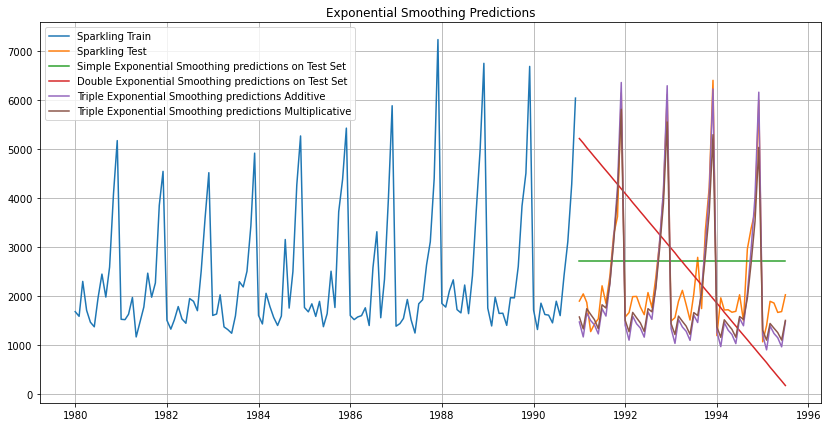

In [33]:
# Forecasting on test set
tes_pred_spark_a = tes_mod_af_spark_a.forecast(steps=len(tes_test_spark))
tes_pred_spark_m = tes_mod_af_spark_m.forecast(steps=len(tes_test_spark))

plt.plot(tes_train_spark, label='Sparkling Train')
plt.plot(tes_test_spark, label='Sparkling Test')

plt.plot(test_pred_mod_spark, label='Simple Exponential Smoothing predictions on Test Set')
plt.plot(test_pred_mod2_spark, label='Double Exponential Smoothing predictions on Test Set')
plt.plot(tes_pred_spark_a, label='Triple Exponential Smoothing predictions Additive')
plt.plot(tes_pred_spark_m, label='Triple Exponential Smoothing predictions Multiplicative')

plt.legend(loc='best')
plt.grid()
plt.title('Exponential Smoothing Predictions');

In [34]:
tes_rmse_mod_test_spark_a = metrics.mean_squared_error(tes_test_spark.values, tes_pred_spark_a.values,squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [tes_rmse_mod_test_spark_a]},index=['Triple Exponential, Additive'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])

In [35]:
tes_rmse_mod_test_spark_m = metrics.mean_squared_error(tes_test_spark.values, tes_pred_spark_m.values,squared=False)
temp_sw_rmse = pd.DataFrame({'RMSE': [tes_rmse_mod_test_spark_m]},index=['Triple Exponential, Multiplicative'])
sw_rmse = pd.concat([sw_rmse, temp_sw_rmse])
sw_rmse

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175
Simple Average,1275.081804
2 Pt Moving Average,813.400684
4 Pt Moving Average,1156.589694
6 Pt Moving Average,1283.927428
9 Pt Moving Average,1346.278315
"Simple Exponential, Alpha=0.05",1316.035487
"Double Exponential, Alpha=0.05",3096.812583
"Triple Exponential, Additive",473.152417


### 5. Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

#### ADF Hypothesis for Sparkling wines
- H0 :  The time series is not stationary
- H1 :  The time series is Stationary

In [36]:
from statsmodels.tsa.stattools import adfuller
def test_stat(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=12, autolag=None)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

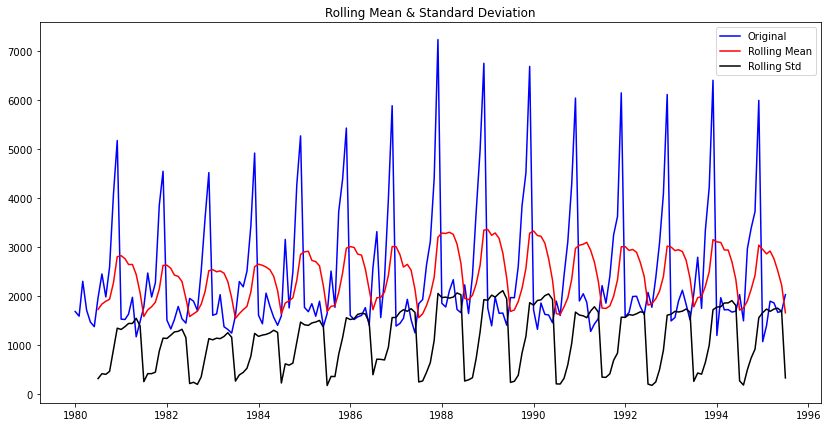

Results of Dickey-Fuller Test:
Test Statistic                  -1.497024
p-value                          0.534983
#Lags Used                      12.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64 



In [37]:
test_stat(dfs)

- P value is greater than 0.05 so cannot reject the null hypothesis


We repeat the test again after converting data to log scale

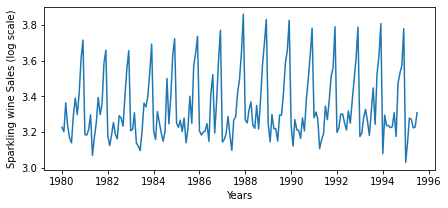

In [38]:
plt.figure(figsize=(7, 3))
plt.plot(np.log10(dfs))
plt.xlabel('Years')
plt.ylabel('Sparkling wine Sales (log scale)');

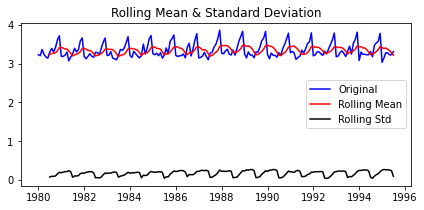

Results of Dickey-Fuller Test:
Test Statistic                  -1.859682
p-value                          0.351259
#Lags Used                      12.000000
Number of Observations Used    174.000000
Critical Value (1%)             -3.468502
Critical Value (5%)             -2.878298
Critical Value (10%)            -2.575704
dtype: float64 



In [39]:
sparkL = np.log10(dfs_new)
sparkL.dropna(inplace=True)
plt.figure(figsize=(7, 3))
test_stat(sparkL)

- p value is greater than 0.05 so we cannot reject the null hypothesis.

We now differentiate in the order of 1.

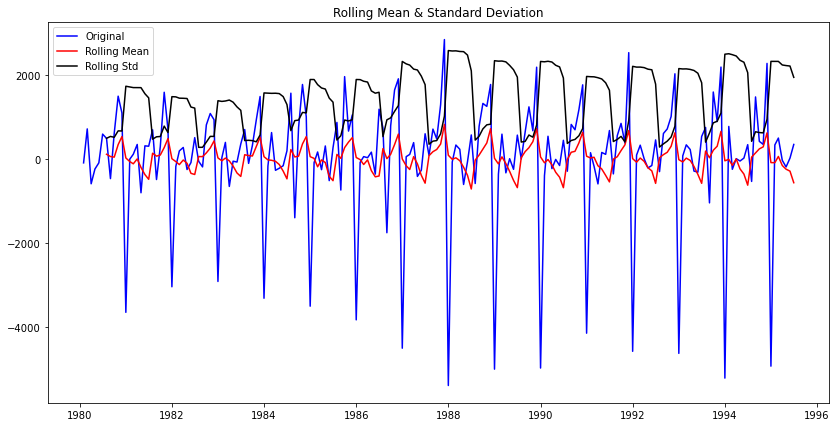

Results of Dickey-Fuller Test:
Test Statistic                -8.958891e+00
p-value                        8.328040e-15
#Lags Used                     1.200000e+01
Number of Observations Used    1.730000e+02
Critical Value (1%)           -3.468726e+00
Critical Value (5%)           -2.878396e+00
Critical Value (10%)          -2.575756e+00
dtype: float64 



In [40]:
spark1 = dfs.diff(periods=1)
spark1.dropna(inplace=True)
test_stat(spark1)

- P value is lower than 0.05, hence series has been converted to stationary
### 6.Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [41]:
import itertools
p = q = range(0, 3)
d = range(0,2) 
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Creating an empty Dataframe with column names
aic_arima = pd.DataFrame(columns=['param', 'AIC'])
aic_arima_sp = pd.DataFrame(columns=['param', 'AIC'])

#### ARIMA model

In [42]:
from statsmodels.tsa.arima_model import ARIMA

for param in pdq:
    arima_mod = ARIMA(train_spark, order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param, arima_mod.aic))
    aic_arima = aic_arima.append({'param':param, 'AIC': arima_mod.aic}, ignore_index=True)

aic_arima.sort_values(by='AIC',ascending=True).head()

ARIMA(0, 0, 0) - AIC:2271.203212328525
ARIMA(0, 0, 1) - AIC:2245.268851396749
ARIMA(0, 0, 2) - AIC:2245.343217655809
ARIMA(0, 1, 0) - AIC:2269.582796371201
ARIMA(0, 1, 1) - AIC:2264.906438611577
ARIMA(0, 1, 2) - AIC:2232.78309768405
ARIMA(1, 0, 0) - AIC:2247.3482759501685
ARIMA(1, 0, 1) - AIC:2245.949094054591
ARIMA(1, 0, 2) - AIC:2246.0121934420395
ARIMA(1, 1, 0) - AIC:2268.5280607650034
ARIMA(1, 1, 1) - AIC:2235.0139453511238
ARIMA(1, 1, 2) - AIC:2233.59764711907
ARIMA(2, 0, 0) - AIC:2244.7999146107504
ARIMA(2, 0, 1) - AIC:2236.590818451348
ARIMA(2, 0, 2) - AIC:2200.9048411419803
ARIMA(2, 1, 0) - AIC:2262.035600155025
ARIMA(2, 1, 1) - AIC:2232.360489884417
ARIMA(2, 1, 2) - AIC:2210.618562220438


,param,AIC
14,"(2, 0, 2)",2200.904841
17,"(2, 1, 2)",2210.618562
16,"(2, 1, 1)",2232.360490
5,"(0, 1, 2)",2232.783098
11,"(1, 1, 2)",2233.597647


In [43]:
# ARIMA(2,0,2) has the lowest AIC
mod_spark = ARIMA(train_spark, order=(2,0,2))
result_arima_spark = mod_spark.fit()

print(result_arima_spark.summary())

                              ARMA Model Results                              
Dep. Variable:              Sparkling   No. Observations:                  132
Model:                     ARMA(2, 2)   Log Likelihood               -1094.452
Method:                       css-mle   S.D. of innovations            933.125
Date:                Mon, 21 Feb 2022   AIC                           2200.905
Time:                        22:21:05   BIC                           2218.202
Sample:                    01-01-1980   HQIC                          2207.933
                         - 12-01-1990                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2399.4078     53.736     44.652      0.000    2294.087    2504.728
ar.L1.Sparkling     1.7210      0.014    124.237      0.000       1.694       1.748
ar.L2.Sparkling    -0.9850      

In [44]:
fin_hat_avg =test_spark.copy()
pred_spark = result_arima_spark.forecast(steps=55)

rmse_spark = mean_squared_error(test_spark, pred_spark[0], squared=False)
result_arsar_spark = pd.DataFrame({'RMSE': [rmse_spark]}, index=['ARIMA (2, 0, 2)'])
result_arsar_spark

,RMSE
"ARIMA (2, 0, 2)",1005.083495


#### SARIMA model

In [45]:
aic_sarima = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(aic_sarima)

import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        sarima_mod = sm.tsa.statespace.SARIMAX(train_spark,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True,
                                            initialization='approximate_diffuse'
                                            )
        
        result_sarima = sarima_mod.fit()
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, result_sarima.aic))
        aic_sarima = aic_sarima.append({'param':param,'seasonal':param_seasonal ,'AIC': result_sarima.aic}, ignore_index=True)

aic_sarima.sort_values(by=['AIC']).head()

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []
SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2466.034766473373
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2339.998217134434
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:2272.41308399855
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2058.4781119934087
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2019.529303907413
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:2042.0204751621156
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2061.0026005819145
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2045.5527094426043
SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:2068.6130643315814
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2023.5642649899046
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2020.5121468855498
SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2042.63353115298
SARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:2069.368534234546
SARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:2066.2204212005913
SARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:2069.8284681676764
SARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:2038.7882129699979
SARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:2039.6728312058108
SARIMA(0, 0, 0)

SARIMA(1, 0, 2)x(0, 1, 2, 12) - AIC:2027.8254304617844
SARIMA(1, 0, 2)x(1, 0, 0, 12) - AIC:2024.4845102536901
SARIMA(1, 0, 2)x(1, 0, 1, 12) - AIC:2007.1095220590908
SARIMA(1, 0, 2)x(1, 0, 2, 12) - AIC:2031.681349582138
SARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:2006.765211885676
SARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:2005.5064707975596
SARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:2026.8716548783523
SARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:2030.102970562683
SARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:2046.9643462655981
SARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:2055.5132947699744
SARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:2020.6282542324923
SARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:2022.4275524746226
SARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:2028.0656121487546
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:2284.372150186775
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:2193.4182996911804
SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:2158.351444739326
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:2062.375131014816
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:2037.2463454550584
SARIMA(1, 1, 0)x

SARIMA(2, 1, 1)x(1, 1, 2, 12) - AIC:2028.0791119061253
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:2070.45349924308
SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:2032.6478143102531
SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:2025.9801728278298
SARIMA(2, 1, 1)x(2, 1, 0, 12) - AIC:2026.4486416727063
SARIMA(2, 1, 1)x(2, 1, 1, 12) - AIC:2027.5150241196861
SARIMA(2, 1, 1)x(2, 1, 2, 12) - AIC:2029.2725225552313
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:2235.0177072833094
SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:2166.1767514514586
SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:2138.210888008992
SARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:2027.5289381482369
SARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:2005.6651942012304
SARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:2028.0142996427403
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:2020.2188715414873
SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:2004.5970695561898
SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:2033.7169146166286
SARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:2008.6850049883835
SARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:2006.4299703508054
SARIMA(2, 1, 

,param,seasonal,AIC
79,"(0, 1, 1)","(1, 0, 1, 12)",1998.790692
187,"(1, 1, 1)","(1, 0, 1, 12)",2001.048003
97,"(0, 1, 2)","(1, 0, 1, 12)",2002.008053
130,"(1, 0, 1)","(0, 1, 1, 12)",2002.139526
76,"(0, 1, 1)","(0, 1, 1, 12)",2002.188623


In [46]:
import statsmodels.api as sm

## SARIMA(0, 1, 1)(1, 0, 1, 12)
smod_s = sm.tsa.statespace.SARIMAX(train_spark,
                                order=(0,1,1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                initialization='approximate_diffuse')
result_sarima_s = smod_s.fit()
print(result_sarima_s.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Sparkling   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -995.395
Date:                            Mon, 21 Feb 2022   AIC                           1998.791
Time:                                    22:27:16   BIC                           2010.322
Sample:                                01-01-1980   HQIC                          2003.476
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8823      0.050    -17.495      0.000      -0.981      -0.783
ar.S.L12       1.0000      0.020   

In [47]:
s_pred_s = result_sarima_s.get_forecast(steps=55)
s_pred_s.predicted_mean

from math import sqrt
rmse = sqrt(mean_squared_error(test_spark, s_pred_s.predicted_mean))

temp_result_df = pd.DataFrame({'RMSE': [rmse]}, index=['SARIMA (1, 0, 0)(1, 0, 1)12'])
result_arsar_spark = pd.concat([result_arsar_spark, temp_result_df])
result_arsar_spark

,RMSE
"ARIMA (2, 0, 2)",1005.083495
"SARIMA (1, 0, 0)(1, 0, 1)12",505.373773


### 7. Build ARIMA/SARIMA models based on the cut-off points of ACF and PACF on the training data and evaluate this model on the test data using RMSE.

#### ARIMA model based on cut off points of ACF and PACF in Sparkling Series

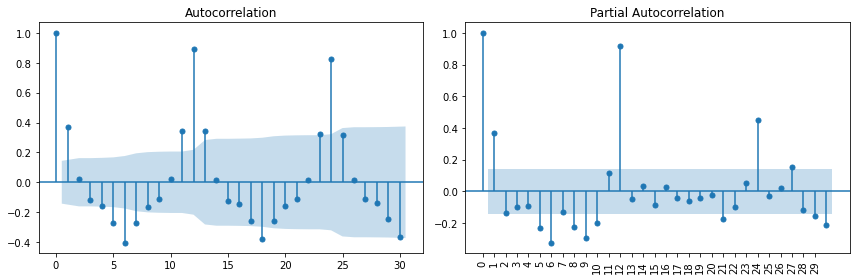

In [48]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(dfs_new, lags=30, ax=axes[0])
smt.graphics.plot_pacf(dfs_new, lags=30, ax=axes[1])
plt.tight_layout()

The lags of ACF & PACF show that the series is not stationary.

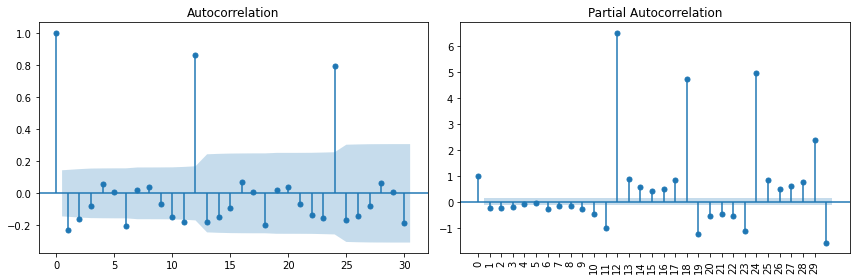

In [49]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(spark1, lags=30, ax=axes[0])
smt.graphics.plot_pacf(spark1, lags=30, ax=axes[1])
plt.tight_layout()

- With one differencing, the series has become stationary as checked with the Augmented Dicky Fuller test as well. so d= 1
- p d q is 4, 1, 3.

In [50]:
# ARIMA(4,1,3) as per the ACF, PACF cutoffs
mod_s413 = ARIMA(train_spark, order=(4,1,3))

result_arima_s413 = mod_s413.fit()

print(result_arima_s413.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Sparkling   No. Observations:                  131
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1104.477
Method:                       css-mle   S.D. of innovations           1072.062
Date:                Mon, 21 Feb 2022   AIC                           2226.955
Time:                        22:27:19   BIC                           2252.831
Sample:                    02-01-1980   HQIC                          2237.469
                         - 12-01-1990                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.0914      3.787      1.608      0.108      -1.332      13.514
ar.L1.D.Sparkling    -0.8162      0.101     -8.105      0.000      -1.014      -0.619
ar.L2.D.Sparkling    -0.

In [51]:
final_hat_avg = test_spark.copy()
pred_sp413 = result_arima_s413.forecast(steps=55)

from sklearn.metrics import  mean_squared_error
rmse_sp413 = mean_squared_error(test_spark,pred_sp413[0],squared=False)

temp_result_df = pd.DataFrame({'RMSE': [rmse_sp413]}, index=['ARIMA (4, 1, 3) ACF/PACF Cutoff'])

result_arsar_spark = pd.concat([result_arsar_spark, temp_result_df])
result_arsar_spark

,RMSE
"ARIMA (2, 0, 2)",1005.083495
"SARIMA (1, 0, 0)(1, 0, 1)12",505.373773
"ARIMA (4, 1, 3) ACF/PACF Cutoff",1398.797957


#### SARIMA model based on cut-off points of ACF & PACF for Sparkling Series
- p d q is 4, 1, 3.
- P D Q is 1, 1, 0.
- S = 12.

In [52]:
## SARIMA(4, 1, 3)(1, 1, 0,12)
mod_s22 = sm.tsa.statespace.SARIMAX(train_spark,
                                order=(4,1,3),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True, 
                                initialization='approximate_diffuse')
result_sarima_s22 = mod_s22.fit()
print(result_sarima_s22.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Sparkling   No. Observations:                  132
Model:             SARIMAX(4, 1, 3)x(1, 1, [], 12)   Log Likelihood                -999.021
Date:                             Mon, 21 Feb 2022   AIC                           2016.043
Time:                                     22:27:20   BIC                           2041.988
Sample:                                 01-01-1980   HQIC                          2026.586
                                      - 12-01-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3985      0.295     -1.349      0.177      -0.977       0.180
ar.L2          0.0858      

In [53]:
pred_s22 = result_sarima_s22.get_forecast(steps=55)
pred_s22.predicted_mean

from math import sqrt
rmse_s22 = sqrt(mean_squared_error(test_spark, pred_s22.predicted_mean))

tDf3s = pd.DataFrame({'RMSE': [rmse_s22]}, index=['SARIMA (1, 1, 3)(1, 1, 1)12 ACF/PACF Cutoff'])

result_arsar_spark = pd.concat([result_arsar_spark, tDf3s])
result_arsar_spark

,RMSE
"ARIMA (2, 0, 2)",1005.083495
"SARIMA (1, 0, 0)(1, 0, 1)12",505.373773
"ARIMA (4, 1, 3) ACF/PACF Cutoff",1398.797957
"SARIMA (1, 1, 3)(1, 1, 1)12 ACF/PACF Cutoff",648.039376


### 8.	Build a table with all the models built along with their corresponding parameters and the respective RMSE values on the test data.

In [54]:
fin_table = pd.concat([sw_rmse, result_arsar_spark])
fin_table

,RMSE
Linear Regression,1389.135175
Naive Model,1389.135175
Simple Average,1275.081804
2 Pt Moving Average,813.400684
4 Pt Moving Average,1156.589694
6 Pt Moving Average,1283.927428
9 Pt Moving Average,1346.278315
"Simple Exponential, Alpha=0.05",1316.035487
"Double Exponential, Alpha=0.05",3096.812583
"Triple Exponential, Additive",473.152417


### 9. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future with appropriate confidence intervals/bands.


Triple Exponential Smoothing Multiplicative & SARIMA (1, 0, 0)(1, 0, 1)12 are the 2 best models.

First we predict using Triple Exponential.

In [55]:
tes_spark = dfs_new.copy()

tes_mod_spark_m = ExponentialSmoothing(tes_spark, trend='additive', seasonal='multiplicative')
tes_mod_af_spark_m = tes_mod_spark_m.fit(optimized=True)
print(tes_mod_af_spark_m.params)

{'smoothing_level': 0.07571455745401173, 'smoothing_trend': 0.07571454342631188, 'smoothing_seasonal': 0.2738622673057031, 'damping_trend': nan, 'initial_level': 1580.0000775636795, 'initial_trend': -15.115514069391871, 'initial_seasons': array([1.07210873, 1.01801011, 1.47119363, 1.19636056, 0.98301056,
       0.95182521, 1.32865861, 1.72362139, 1.38754379, 1.90772463,
       2.931746  , 3.80627747]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


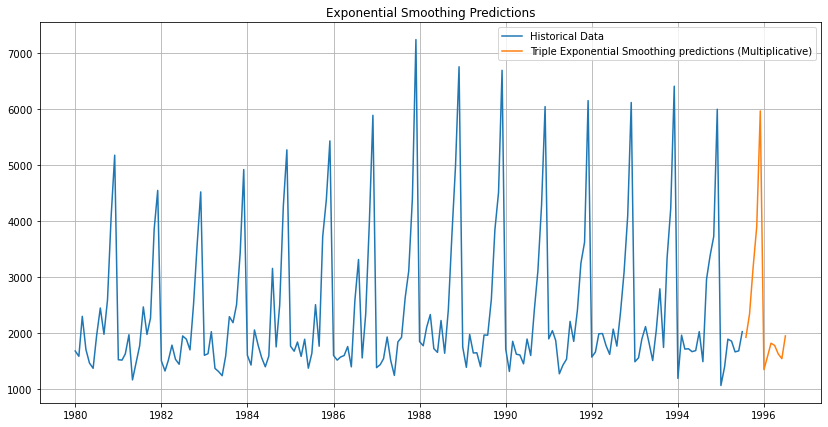

In [56]:
# Forecasting on test set
tes_pred_spark_m = tes_mod_af_spark_m.forecast(steps=12)

plt.plot(tes_spark, label='Historical Data')
plt.plot(tes_pred_spark_m, label='Triple Exponential Smoothing predictions (Multiplicative)')

plt.legend(loc='best')
plt.grid()
plt.title('Exponential Smoothing Predictions');

Now, we predict using SARIMAX (1, 0, 0)(1, 0, 1)12 model.

                                      SARIMAX Results                                       
Dep. Variable:                            Sparkling   No. Observations:                  187
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood               -1406.185
Date:                              Mon, 21 Feb 2022   AIC                           2820.370
Time:                                      22:27:21   BIC                           2833.295
Sample:                                  01-01-1980   HQIC                          2825.607
                                       - 07-01-1995                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3300      0.042      7.839      0.000       0.247       0.412
ar.S.L12       1.00

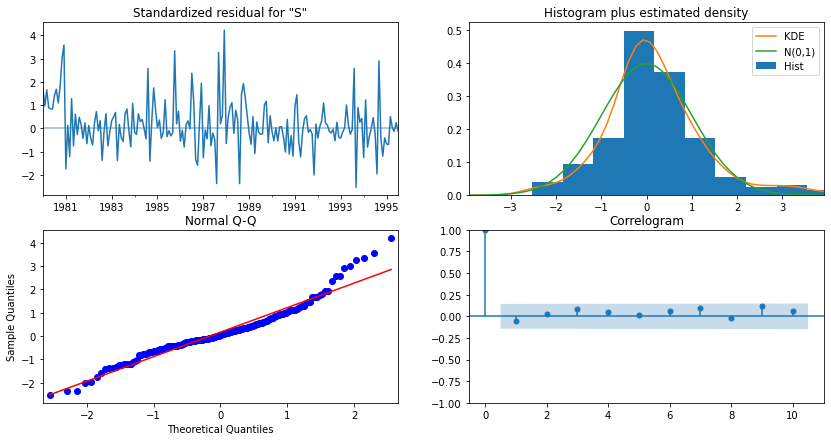

In [57]:
mod_sp = sm.tsa.statespace.SARIMAX(dfs,
                                order=(1,0,0),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                initialization='approximate_diffuse')
best_results_sp = mod_sp.fit()
print(best_results_sp.summary())

best_results_sp.plot_diagnostics(figsize=(14, 7))
plt.show()

In [58]:
# Get forecast for 12 months
n_steps = 12
pred_u_s_99 = best_results_sp.get_forecast(steps=n_steps, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_u_s_95 = best_results_sp.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 signifies 95% confidence interval

pred_c_s_99 = pred_u_s_99.conf_int()
pred_c_s_95 = pred_u_s_95.conf_int()

idx = pd.date_range(dfs.index[-1], periods=n_steps, freq='MS')

fc_s_95 = pd.DataFrame(np.column_stack([ pred_u_s_95.predicted_mean,  pred_c_s_95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_s_99 = pd.DataFrame(np.column_stack([pred_c_s_99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])

fc_s_all = fc_s_95.combine_first(fc_s_99)
fc_s_all = fc_s_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']]

fc_s_all

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1995-07-01,1906.954038,1153.948471,2659.959604,1153.948471,2659.959604
1995-08-01,2492.563841,1699.623652,3285.504031,1699.623652,3285.504031
1995-09-01,3319.184754,2522.017247,4116.352260,2522.017247,4116.352260
1995-10-01,3957.426345,3159.799922,4755.052768,3159.799922,4755.052768
1995-11-01,6159.667046,5361.990672,6957.343420,5361.990672,6957.343420
1995-12-01,1262.779040,465.097227,2060.460853,465.097227,2060.460853
1996-01-01,1611.773261,814.090859,2409.455664,814.090859,2409.455664
1996-02-01,1859.192193,1061.509726,2656.874659,1061.509726,2656.874659
1996-03-01,1844.045572,1046.363099,2641.728046,1046.363099,2641.728046
1996-04-01,1690.104260,892.421786,2487.786735,892.421786,2487.786735


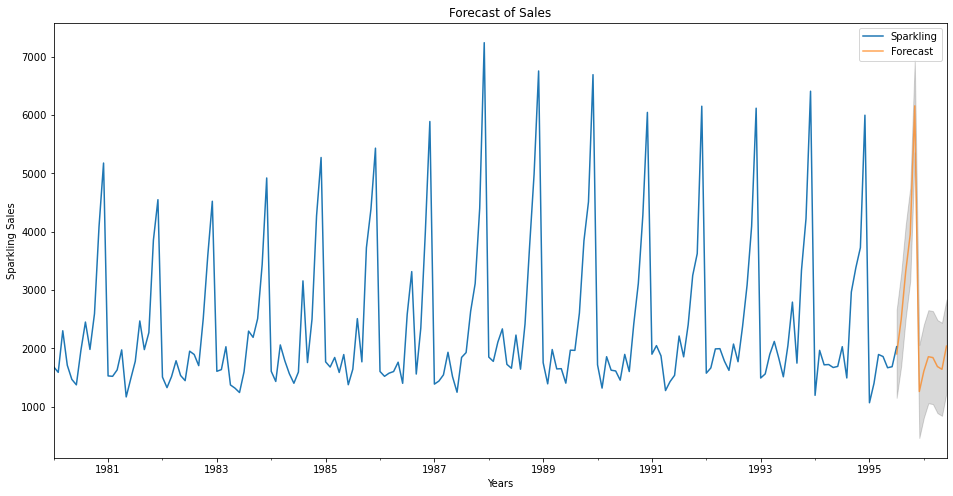

In [59]:
axis = dfs.plot(label='Observed', figsize=(16, 8))
fc_s_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_s_all.index, fc_s_all['lower_ci_95'], fc_s_all['upper_ci_95'], color='k', alpha=.15)

axis.set_xlabel('Years')
axis.set_ylabel('Sparkling Sales')
plt.legend(loc='best')

plt.title("Forecast of Sales")
plt.show()

### 10.	Comment on the model thus built and report your findings and suggest the measures that the company should be taking for future sales.

- We have predicted the future sales for 12 months for Sparkling Wines.
- My suggestion would be to manufacture Sparkling wine according to the seasonality.
- There seems to be no macro trend for the sales of Sparkling wines.
- The company would be able to maintain its current profitability, however, there is not much scope for growth. 
- The company can perform market research to identify other products which have an increasing macro trend, and then explore selling other products.